In [1]:
import numpy as np
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

import notebooks.plotting_functions as pf
from src.post_processing import smooth_proba
import pickle
import matplotlib.pyplot as plt
import joblib



/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**Load frames and features, predict blinks, load ground truth, compute IOU**

In [6]:
iclip = 0

clip_names = pf.get_clip_names()

# Load data and features
ts, features, left_images, right_images = pf.load_imgs_and_features(clip_names[iclip])

# Predict blinks
predicted_blink_on, predicted_blink_off, blink_events, proba = pf.predict_blinks(ts, features)

# Load ground truth blinks
blink_on_idx, blink_off_idx, _ = pf.load_gt_blinks(clip_names[iclip], ts)

pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

# Compute IOU
iou_results, true_positives, false_negatives, false_positives = pf.compute_multiple_iou(gt, pred, iou_threshold=0.2)



**CREATE VIDEO OF FALSE POSITIVES**

In [ ]:
# file path
fp = "/users/tom/git/neon_blink_detection/blink_videos/"

for i in range(len(false_positives)):

    fn = fp + "false_positive_" + str(i) + ".mp4"

    video_left = left_images[false_positives[i][1][0]:false_positives[i][1][1],:,:]
    video_right = right_images[false_positives[i][1][0]:false_positives[i][1][1],:,:]

    corr_proba = proba[false_positives[i][1][0]:false_positives[i][1][1], :]

    pf.generate_video(video_left, video_right, corr_proba, fn) 

**CREATE VIDEO OF FALSE NEGATIVES**

In [40]:
for i in range(len(false_negatives)):

    fn = fp + "false_negative_" + str(i) + ".mp4"

    video_left = left_images[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]
    video_right = right_images[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]

    corr_proba = proba[false_positives[i][1][0]:false_positives[i][1][1], :]
                       
    pf.generate_video(video_left, video_right, corr_proba, fn) 

**VIDEOS OF TRUE POSITIVES**

In [ ]:
for i in range(len(false_negatives)):

    fn = fp + "true_positive_" + str(i) + ".mp4"

    video_left = left_images[true_positives[i][1][0]:true_positives[i][1][1],:,:]
    video_right = right_images[true_positives[i][1][0]:true_positives[i][1][1],:,:]

    corr_proba = proba[false_positives[i][1][0]:false_positives[i][1][1], :]
                       
    pf.generate_video(video_left, video_right, corr_proba, fn) 

**PLOT GROUND TRUTH AND PREDICTED BLINKS**

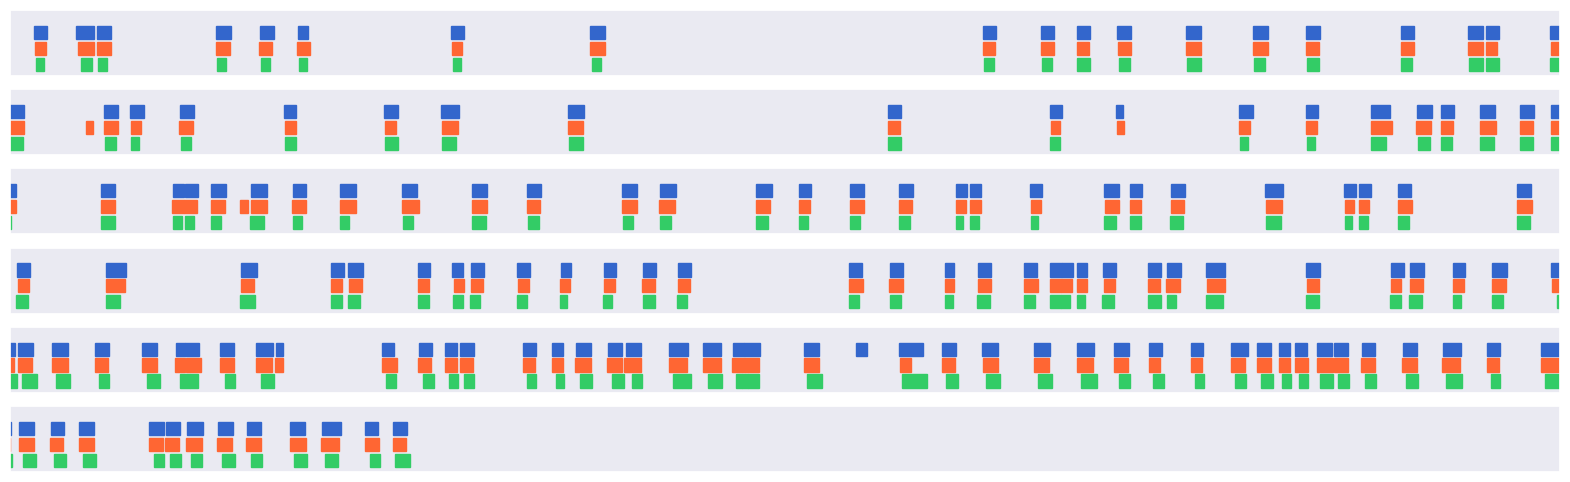

In [2]:
colors = [[0.2, 0.8, 0.4], [1, 0.4, 0.2], [0.2, 0.4, 0.8]]

clip_name = "1156-2023-01-13-15-15-36-93d791d5"

# Load data and features
ts, features, left_images, right_images = pf.load_imgs_and_features(clip_name)

# Load ground truth blinks
blink_on_idx, blink_off_idx, _ = pf.load_gt_blinks(clip_name, ts)

# Predict blinks with XGBoost and CNN
pred_on_xgb, pred_off_xgb = pf.xgb_predictions(features, ts)
pred_on_cnn, pred_off_cnn = pf.cnn_predictions(features, ts)

total_duration = np.ceil(len(ts)/200)
subplot_duration = 30  # duration of each subplot in seconds
num_subplots = int(np.ceil(total_duration / subplot_duration))

f, ax = plt.subplots(num_subplots, 1)
f.set_size_inches(20, 20 * num_subplots / 20)

time_intervals = [(i * 30, (i + 1) * 30) for i in range(num_subplots)]

for i, (start, end) in enumerate(time_intervals):
    pf.create_subplot(ax[i], blink_on_idx, blink_off_idx, pred_on_xgb, pred_off_xgb, pred_on_cnn, pred_off_cnn, start, end, colors)
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)


In [280]:
data_dict = {}
clip_names = pf.get_clip_names()
clf = joblib.load("/users/tom/git/neon_blink_detection/weights/xgb.sav")

for clip_name in clip_names:
    print("Processing clip %s" %(clip_name))

    clip_data = {
        
        'confidence_probas_tp': [],
        'confidence_li_tp': [],
        'confidence_ri_tp': [],
        'confidence_blink_tp': [],

        'confidence_probas_fp': [],
        'confidence_li_fp': [],
        'confidence_ri_fp': [],
        'confidence_blink_fp': [],

        'true_positives': [],
        'false_positives': [],
    }

    _, pp_params = pf.get_params()

    pred_blink, gt_blinks, proba, li, ri = pf.get_blink_events(clip_name, clf)
    smoothed_proba = smooth_proba(proba, pp_params)
    
    iou_results, true_positives, false_negatives, false_positives = pf.compute_multiple_iou(gt_blinks, pred_blink)

    clip_data['true_positives'] = [(true_positives[x][0], tuple(np.array(true_positives[x][1]))) for x in range(len(true_positives))]

    clip_data['false_positives'] = [(false_positives[x][0], tuple(np.array(false_positives[x][1]))) for x in range(len(false_positives))]

    print("Number of false positives: {}".format(len(false_positives)))

    for i in range(len(true_positives)):
        start_idx = true_positives[i][1][0]
        end_idx = true_positives[i][1][1]

        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = pf.compute_confidence(start_idx, end_idx, smoothed_proba)

        clip_data['confidence_blink_tp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_tp'].append(smoothed_proba[start_idx:end_idx, :])  
        clip_data['confidence_li_tp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_tp'].append(ri[start_idx:end_idx, :, :])

    for i in range(len(false_positives)):
        start_idx = false_positives[i][1][0]
        end_idx = false_positives[i][1][1]

        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = pf.compute_confidence(start_idx, end_idx, smoothed_proba)

        clip_data['confidence_blink_fp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_fp'].append(smoothed_proba[start_idx:end_idx, :])
        clip_data['confidence_li_fp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_fp'].append(ri[start_idx:end_idx, :, :])

    data_dict[clip_name] = clip_data

Processing clip 2023-03-01_09-59-07-2ea49126
Number of false positives: 12
Processing clip 2023-01-27_15-59-54-49a115d5
Number of false positives: 3
Processing clip 2023-02-01_11-45-11-7621531e
Number of false positives: 21
Processing clip 2023-01-27_16-10-14-a2a8cbe1
Number of false positives: 2
Processing clip 2023-01-27_16-15-26-57802f75
Number of false positives: 4
Processing clip 2023-01-27_16-24-04-eb4305b1
Number of false positives: 8
Processing clip 2023-01-27_16-31-52-5f743ed0
Number of false positives: 0
Processing clip padel_tennis_neon_01-b922b245
Number of false positives: 7
Processing clip padel_tennis_neon_03-2ded8f56
Number of false positives: 2


[(0, (173, 212)),
 (1, (2390, 2432)),
 (2, (2432, 2479)),
 (3, (2801, 2843)),
 (7, (3124, 3171)),
 (8, (3221, 3272)),
 (9, (3489, 3521)),
 (10, (3605, 3679)),
 (11, (3989, 4012)),
 (12, (4097, 4159)),
 (13, (4249, 4298)),
 (15, (4480, 4531)),
 (16, (4880, 4916)),
 (17, (4993, 5035)),
 (18, (5070, 5107)),
 (19, (5412, 5455)),
 (20, (5546, 5588)),
 (22, (6121, 6165)),
 (23, (6574, 6615)),
 (24, (6841, 6881)),
 (25, (6991, 7032)),
 (26, (7180, 7247)),
 (27, (7320, 7377)),
 (28, (7713, 7753)),
 (29, (8049, 8089)),
 (30, (8201, 8242)),
 (31, (8992, 9033)),
 (32, (9191, 9238)),
 (33, (9458, 9504)),
 (34, (9639, 9724)),
 (35, (9770, 9828)),
 (36, (9890, 9932)),
 (37, (10150, 10196)),
 (38, (10348, 10393)),
 (39, (10607, 10651)),
 (40, (10768, 10814)),
 (41, (10901, 10950)),
 (42, (11125, 11173)),
 (43, (11540, 11602)),
 (44, (11612, 11666)),
 (45, (11740, 11793)),
 (47, (12433, 12498)),
 (48, (12546, 12596)),
 (49, (12752, 12809)),
 (50, (13135, 13176)),
 (51, (13396, 13443)),
 (52, (13594, 1

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.hist(clip_data['confidence_blink_tp'], bins=20, alpha=0.5, label="True Positives", density=False)
ax.hist(clip_data['confidence_blink_fp'], bins=20, alpha=0.5, label="False Positives", density=False)
ax.set_xlabel("Blink Confidence")
ax.set_ylabel("Count")
ax.legend(loc="upper right")
# ax.set_ylim(0, 10)

**CREATE VIDEO SHOWING CONFIDENCE AND PROBABILITIES**

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
sns.set()

iclip = 5

confidence_blink = np.array(data_dict[clip_names[iclip]]['confidence_blink_tp'])
confidence_blink_sorted_idx = np.argsort(confidence_blink)

index = confidence_blink_sorted_idx[0]
print(index)

fig, axs = plt.subplots(2, 2)

video_left = data_dict[clip_names[iclip]]["confidence_li_tp"][index]
video_right = data_dict[clip_names[iclip]]["confidence_ri_tp"][index]

fig.set_size_inches(8, 6)
im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
axs[0, 0].axis("off")
axs[0, 1].axis("off")

plt.close() 

axs[1, 0].plot(data_dict[clip_names[iclip]]['confidence_probas_tp'][index])
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel("Frame")
axs[1, 0].set_ylabel("Probability")
axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

# Create a vertical line object
vline = axs[1, 0].axvline(x=0, color=[0.5, 0.5, 0.5], linestyle=':')

axs[1, 1].text(0.5, 0.5, "Blink Confidence: %.2f" %(confidence_blink[index]), fontsize=14, ha='center')
axs[1, 1].text(0.5, 0.3, "Start: %.2f" %(data_dict[clip_names[iclip]]['true_positives'][index][0]), fontsize=12, ha='center')
# add clip name
axs[1, 1].text(0.5, 0.2, "Clip: %s" %(clip_names[iclip]), fontsize=12, ha='center')
axs[1, 1].axis("off")

def init():
    im0.set_data(video_left[0,:,:])
    im1.set_data(video_right[0,:,:])
    vline.set_xdata(0)

def animate(frame):
    im0.set_data(video_left[frame,:,:])
    im1.set_data(video_right[frame,:,:])
    vline.set_xdata(frame) # Update the vertical line position

    return im0, im1, vline

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

# anim.save('/users/tom/blink_videos/false_positive_example_%.2f.mp4' %(confidence_blink[index]), extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())


130


/tmp/ipykernel_1974539/2854225168.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(0)
/tmp/ipykernel_1974539/2854225168.py:51: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(frame) # Update the vertical line position


<font size = 4>**Load classifier weights and class probabilities**

In [67]:

from training.dataset_splitter import load_dataset_splitter
import warnings
warnings.filterwarnings("default")

path = "/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow/all_timestamps.pkl"

with open(path, "rb") as f:
    all_timestamps = pickle.load(f)
    
def compute_confidence(type="mean", prctile=None):

    tp_confidence = {}
    fp_confidence = {}

    blink_info = {}

    dataset_splitter = load_dataset_splitter(n_clips=None, n_splits=5)
    for idx, (_, clip_tuples_val) in enumerate(dataset_splitter):

        print(idx)

        if idx==0:
            continue

        # Load XGBoost classifier
        # ---------------------
        clf = "/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/weights-%d.sav" %idx

        # Load XGBoost model output
        # -------------------- 
        # all_probas = np.load("/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/proba-%d.npy" %idx, allow_pickle=True)

        # Load CNN model output
        # --------------------
        all_probas = np.load("/users/tom/git/neon_blink_detection/export-XGBClassifier-3-310320230902/n_lay5-lay_intv7-grid7-win11-trans0.0-scale0.0-speed0.0/proba-%d.npy" %idx, allow_pickle=True)

        for clip_name in clip_tuples_val:

            print(clip_name)

            tp_confidence[clip_name] = []
            fp_confidence[clip_name] = []

            pred_blink, gt_blinks, _, _, _ = pf.get_blink_events(clip_name, clf, all_probas[clip_name], all_timestamps)

            _, pp_params = pf.get_params()

            smoothed_proba = smooth_proba(all_probas[clip_name], pp_params)
            _, tp, fn, fp = pf.compute_multiple_iou(gt_blinks, pred_blink)


            fpr, br, blink_nr = pf.compute_fpr_and_br(clip_name, fp, tp, fn, all_timestamps)

            blink_info[clip_name] = {}
            blink_info[clip_name]["tp"] = tp
            blink_info[clip_name]["fp"] = fp
            blink_info[clip_name]["fn"] = fn
            blink_info[clip_name]["br"] = br
            blink_info[clip_name]["fpr"] = fpr
            blink_info[clip_name]["blink_nr"] = blink_nr
            blink_info[clip_name]["gt"] = gt_blinks
            blink_info[clip_name]["smoothed_proba"] = smoothed_proba

            for i in range(len(tp)):
                start_idx = tp[i][1][0]
                end_idx = tp[i][1][1]

                confidence_blink_tmp, _, _ = pf.compute_confidence(start_idx, end_idx, smoothed_proba, type=type, prctile=prctile)
                tp_confidence[clip_name].append(confidence_blink_tmp)

            for i in range(len(fp)):
                start_idx = fp[i][1][0]
                end_idx = fp[i][1][1]

                confidence_blink_tmp, _, _ = pf.compute_confidence(start_idx, end_idx, smoothed_proba, type=type, prctile=prctile)
                fp_confidence[clip_name].append(confidence_blink_tmp)
                        
    return tp_confidence, fp_confidence, blink_info

dataset_splitter = load_dataset_splitter(n_clips=None, n_splits=5)
tp_confidence, fp_confidence, blink_info = compute_confidence(type="mean")

/users/tom/git/neon_blink_detection/training/dataset_splitter.py:84: ResourceWarning: unclosed file <_io.BufferedWriter name='/users/tom/git/neon_blink_detection/dataset_splitter-89-5.pkl'>
  pickle.dump(self, open(path, "wb"))


72 training clips & 17 validation clips.
72 training clips & 17 validation clips.
0
1
1000-2022-12-14-09-43-56-0fcac6d3
1002-2022-12-14-11-43-58-23e05b8c
1004-2022-12-14-13-14-14-c8a509b9
1005-2022-12-14-15-07-31-ba8d94d5
1010-2022-12-15-13-27-31-f46dcdd8
1140-2023-01-12-13-15-56-2f0172d2
1141-2023-01-12-14-17-58-470c61da
1142-2023-01-12-14-27-07-34f1fccf
1144-2023-01-12-16-36-04-2c1ecc99
1151-2023-01-13-12-03-16-bca271ec
1152-2023-01-13-13-03-33-ddabe2a5
1156-2023-01-13-15-15-36-93d791d5
1167-2023-01-16-15-28-05-761a32fb
1190-2023-01-18-11-47-36-4663855c
1199-2023-01-19-10-39-37-cbad3d47
1201-2023-01-19-11-43-16-41f36271
1287-2023-01-31-11-44-32-c6118754
2
1202-2023-01-19-13-17-50-3651315a
1219-2023-01-23-10-52-53-f0f1506f
1230-2023-01-24-10-34-24-8e573035
1250-2023-01-25-15-28-28-e49f5c02
1253-2023-01-26-11-39-39-c0de66cb
1280-2023-01-30-14-24-40-d879dc2a
1293-2023-02-01-10-13-34-0c9638f8
1294-2023-02-01-11-11-04-442d1d78
1297-2023-02-01-13-37-41-668a3c8e
1298-2023-02-01-14-29-40-080

<font size=4>**Plotting**

In [65]:
tp_confidence

{'1000-2022-12-14-09-43-56-0fcac6d3': [0.7180836796760559,
  0.7215577363967896,
  0.4942680597305298,
  0.729421854019165,
  0.6253628730773926,
  0.4662572741508484,
  0.7135992646217346,
  0.7420782446861267,
  0.7723163366317749,
  0.7430229187011719,
  0.7433773279190063,
  0.7253751158714294,
  0.7444803714752197,
  0.7607415914535522,
  0.7539045214653015,
  0.6599389314651489,
  0.7115387916564941,
  0.7699549794197083,
  0.7562823295593262,
  0.6944829225540161,
  0.47682034969329834,
  0.7299176454544067,
  0.7171210050582886,
  0.4409106969833374,
  0.5836472511291504,
  0.6435472965240479,
  0.7190017700195312,
  0.4698968529701233,
  0.6577858924865723,
  0.6608119010925293,
  0.6982962489128113],
 '1002-2022-12-14-11-43-58-23e05b8c': [0.7510740756988525,
  0.7603719830513,
  0.7078118324279785,
  0.5852358341217041,
  0.516633152961731,
  0.7758731842041016,
  0.7242137789726257,
  0.6043578386306763,
  0.6823633909225464,
  0.7717850208282471],
 '1004-2022-12-14-13-14-14

Plot histograms of blink rate, false positive rate and total number of blinks

Text(0.5, 0, 'Number of blinks')

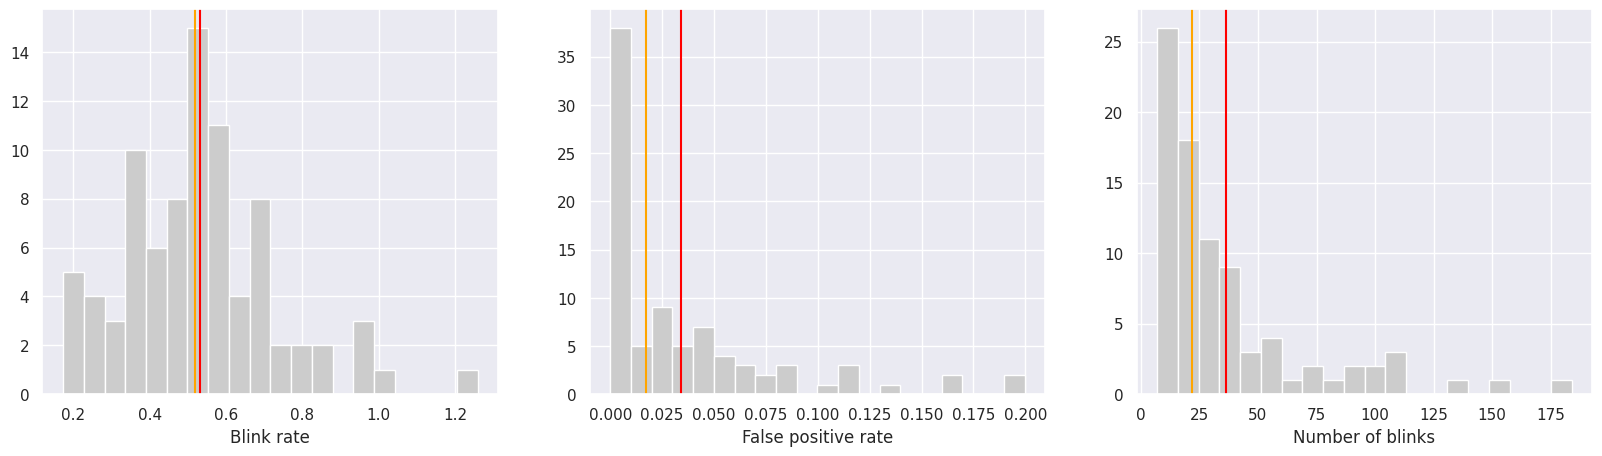

In [68]:
import matplotlib.pyplot as plt

br = [blink_info[x]["br"] for x in blink_info.keys()]
fpr = [blink_info[x]["fpr"] for x in blink_info.keys()]
blink_nr = [blink_info[x]["blink_nr"] for x in blink_info.keys()]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(br, bins=20, color=[0.8, 0.8, 0.8])
ax[0].axvline(np.mean(br), color="red")
ax[0].axvline(np.median(br), color="orange")
ax[0].set_xlabel("Blink rate")

ax[1].hist(fpr, bins=20, color=[0.8, 0.8, 0.8])
ax[1].axvline(np.mean(fpr), color="red")
ax[1].axvline(np.median(fpr), color="orange")
ax[1].set_xlabel("False positive rate")

ax[2].hist(blink_nr, bins=20, color=[0.8, 0.8, 0.8])
ax[2].axvline(np.mean(blink_nr), color="red")
ax[2].axvline(np.median(blink_nr), color="orange")
ax[2].set_xlabel("Number of blinks")


**Plot histgrams of true and false positives**

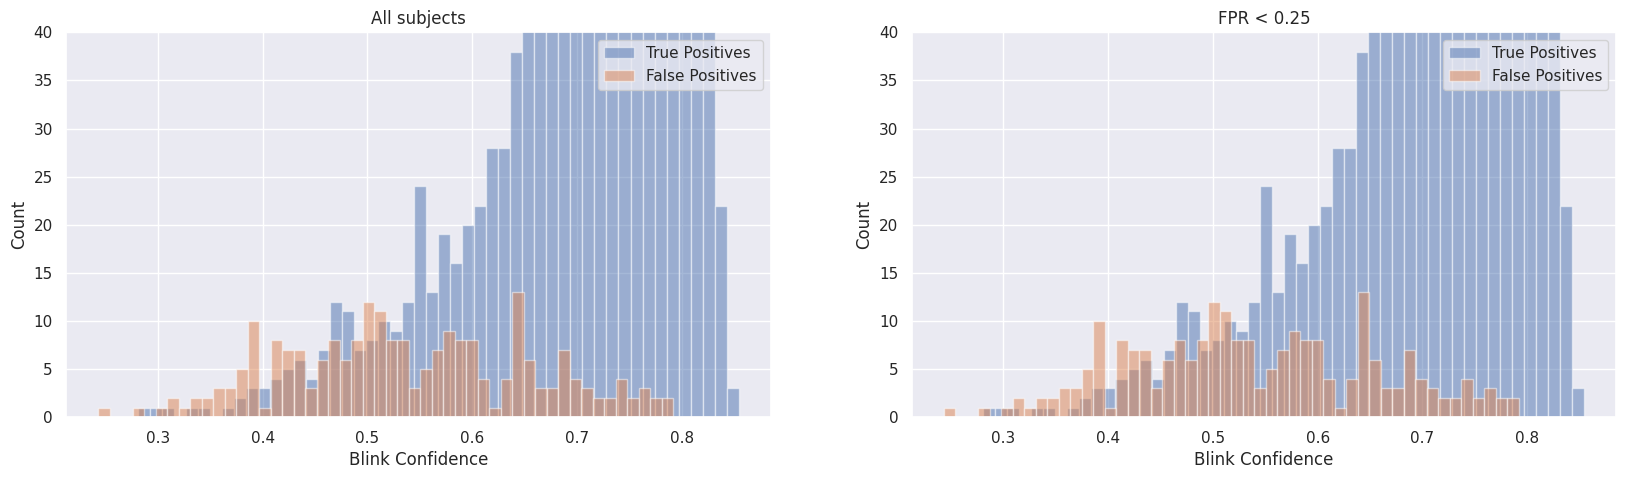

In [69]:
def plot_histogram_confidence(tp_confidence, fp_confidence, ax, title):

    ax.hist(tp_confidence, bins=50, alpha=0.5, label="True Positives", density=False)
    ax.hist(fp_confidence, bins=50, alpha=0.5, label="False Positives", density=False)
    ax.set_xlabel("Blink Confidence")
    ax.set_ylabel("Count")
    ax.legend(loc="upper right")
    ax.set_ylim(0, 40)
    ax.set_title(title)

true_pos_conf = np.concatenate([list(tp_confidence[x]) for x in tp_confidence.keys()])
false_pos_conf = np.concatenate([list(fp_confidence[x]) for x in tp_confidence.keys()])

f, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[0], "All subjects")

# extract subject ids with fpr < 0.25
fpr_threshold = 0.25
# -----------

subject_ids = []
for subject_id in blink_info.keys():
    if blink_info[subject_id]["fpr"] < fpr_threshold:
        subject_ids.append(subject_id)
    else:
        # print the subject id and fpr
        print("Subj %s: FPR = %.2f" %(subject_id, blink_info[subject_id]["fpr"]))

true_pos_conf = []
false_pos_conf = []
for subject_id in subject_ids:
    true_pos_conf.extend(tp_confidence[subject_id])
    false_pos_conf.extend(fp_confidence[subject_id])

plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[1], "FPR < %.2f" %fpr_threshold)

/users/tom/git/neon_blink_detection/training/dataset_splitter.py:84: ResourceWarning: unclosed file <_io.BufferedWriter name='/users/tom/git/neon_blink_detection/dataset_splitter-89-5.pkl'>
  pickle.dump(self, open(path, "wb"))


72 training clips & 17 validation clips.
72 training clips & 17 validation clips.
0
1
1000-2022-12-14-09-43-56-0fcac6d3
1002-2022-12-14-11-43-58-23e05b8c
1004-2022-12-14-13-14-14-c8a509b9
1005-2022-12-14-15-07-31-ba8d94d5
1010-2022-12-15-13-27-31-f46dcdd8
1140-2023-01-12-13-15-56-2f0172d2
1141-2023-01-12-14-17-58-470c61da
1142-2023-01-12-14-27-07-34f1fccf
1144-2023-01-12-16-36-04-2c1ecc99
1151-2023-01-13-12-03-16-bca271ec
1152-2023-01-13-13-03-33-ddabe2a5
1156-2023-01-13-15-15-36-93d791d5
1167-2023-01-16-15-28-05-761a32fb
1190-2023-01-18-11-47-36-4663855c
1199-2023-01-19-10-39-37-cbad3d47
1201-2023-01-19-11-43-16-41f36271
1287-2023-01-31-11-44-32-c6118754
2
1202-2023-01-19-13-17-50-3651315a
1219-2023-01-23-10-52-53-f0f1506f
1230-2023-01-24-10-34-24-8e573035
1250-2023-01-25-15-28-28-e49f5c02
1253-2023-01-26-11-39-39-c0de66cb
1280-2023-01-30-14-24-40-d879dc2a
1293-2023-02-01-10-13-34-0c9638f8
1294-2023-02-01-11-11-04-442d1d78
1297-2023-02-01-13-37-41-668a3c8e
1298-2023-02-01-14-29-40-080

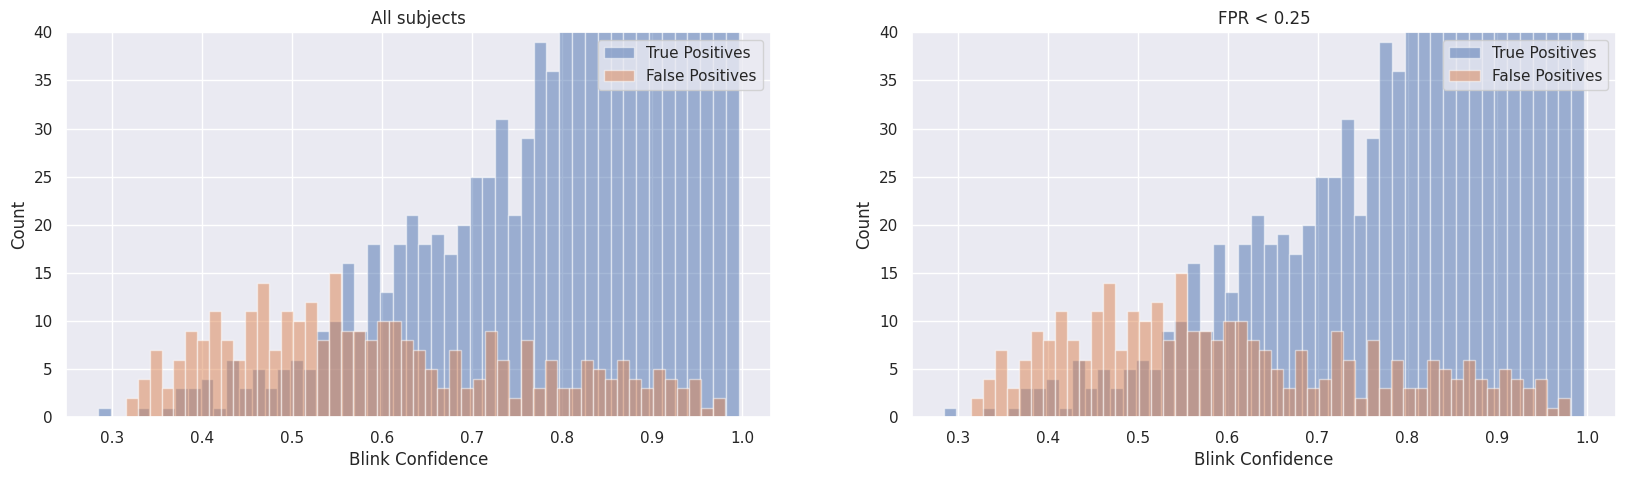

In [63]:
dataset_splitter = load_dataset_splitter(n_clips=None, n_splits=5)
tp_confidence, fp_confidence, blink_info = compute_confidence(type="percentile", prctile=0.25)

true_pos_conf = np.concatenate([list(tp_confidence[x]) for x in tp_confidence.keys()])
false_pos_conf = np.concatenate([list(fp_confidence[x]) for x in tp_confidence.keys()])

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 5)

plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[0], "All subjects")

# extract subject ids with fpr < 0.25
fpr_threshold = 0.25
subject_ids = []
for subject_id in blink_info.keys():
    if blink_info[subject_id]["fpr"] < fpr_threshold:
        subject_ids.append(subject_id)
    else:
        # print the subject id and fpr
        print("Subj %s: FPR = %.2f" %(subject_id, blink_info[subject_id]["fpr"]))

# extract true positive confidence and false positive confidence for these subjects
true_pos_conf = []
false_pos_conf = []
for subject_id in subject_ids:
    true_pos_conf.extend(tp_confidence[subject_id])
    false_pos_conf.extend(fp_confidence[subject_id])

plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[1], "FPR < %.2f" %fpr_threshold)

In [ ]:
all_br = [br[x] for x in br.keys()]
all_fpr = [fpr[x] for x in fpr.keys()]

plt.scatter(all_br, all_fpr, ec="w", fc="k")
plt.xlabel("Blink rate")
plt.ylabel("False positive rate")   

**PLOT SCORES AS FUNCTION OF CONFIDENCE THRESHOLD**

(0.0, 60.0)

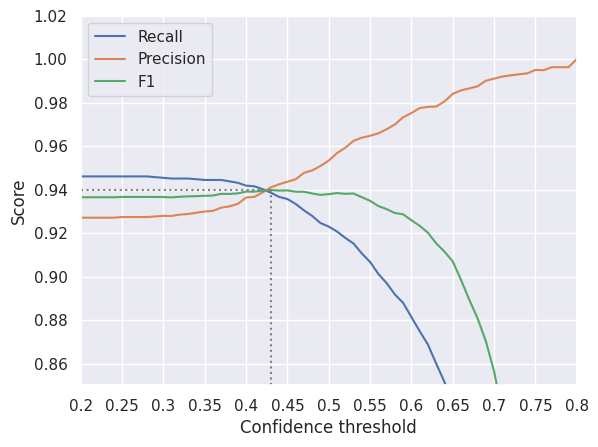

In [70]:
confidence_thresholds = np.arange(0.2, 0.8, 0.01)

f1 = {}
recall = {}
precision = {}
accuracy = {}

for confidence_threshold in confidence_thresholds:

    tp = sum([len(blink_info[x]["tp"]) for x in blink_info.keys()])
    fp = sum([len(blink_info[x]["fp"]) for x in blink_info.keys()])
    fn = sum([len(blink_info[x]["fn"]) for x in blink_info.keys()])
    blinks = sum([blink_info[x]["blink_nr"] for x in blink_info.keys()])

    f1[confidence_threshold] = []
    recall[confidence_threshold] = []
    precision[confidence_threshold] = []

    for subject_id in blink_info.keys():
        for confidence in tp_confidence[subject_id]:
            if confidence < confidence_threshold:
                tp -= 1
                fn += 1
             
        for confidence in fp_confidence[subject_id]:
            if confidence < confidence_threshold:
                fp -= 1

    recall[confidence_threshold].append(tp / (tp + fn))

    if tp == 0 and fp == 0:
        precision[confidence_threshold].append(1)
    else:
        precision[confidence_threshold].append(tp / (tp + fp))

    f1[confidence_threshold].append(2 * (precision[confidence_threshold][-1] * recall[confidence_threshold][-1]) / (precision[confidence_threshold][-1] + recall[confidence_threshold][-1]))
    
    accuracy[confidence_threshold] = tp / blinks

plt.plot([np.mean(recall[x]) for x in recall.keys()])
plt.plot([np.mean(precision[x]) for x in precision.keys()])
plt.plot([np.mean(f1[x]) for x in f1.keys()])

plt.legend(["Recall", "Precision", "F1"])
plt.xlabel("Confidence threshold")
plt.ylabel("Score")

# x-labels
plt.xticks(np.arange(0, len(confidence_thresholds), 5), [round(x, 2) for x in confidence_thresholds[::5]])

ymax=np.max([np.mean(f1[x]) for x in f1.keys()])
xmax=np.argmax([np.mean(f1[x]) for x in f1.keys()])

# plot horitontal dashed line where the maximum f1 score is
plt.axhline(y=ymax, xmax=xmax/60 ,color=[0.5, 0.5, 0.5], linestyle=":")


plt.axvline(x=np.argmax([np.mean(f1[x]) for x in f1.keys()]), color=[0.5, 0.5, 0.5], linestyle=":",  ymax=(ymax-0.85)/0.17)

plt.ylim(0.85, 1.02)
plt.xlim(0, 60)

        

In [52]:
a=[tp_confidence[subject_id] for subject_id in tp_confidence.keys()]
[max(a[x]) for x in range(len(a))]

[0.7723163366317749,
 0.7758731842041016,
 0.8341484069824219,
 0.7919832468032837,
 0.7759193778038025,
 0.7864953279495239,
 nan,
 0.7685523629188538,
 0.8029959201812744,
 0.7927844524383545,
 0.7994632720947266,
 0.7937377095222473,
 0.8086031675338745,
 0.7833405137062073,
 0.7219411134719849,
 0.8000847101211548,
 0.7935242652893066,
 0.8262686133384705,
 0.7616605162620544,
 0.8161875009536743,
 0.8057557940483093,
 0.7676650285720825,
 0.7908397912979126,
 0.7552752494812012,
 0.7702585458755493,
 0.7879414558410645,
 0.7842205762863159,
 0.787817120552063,
 0.7726095914840698,
 0.7421577572822571,
 0.7675148248672485,
 0.7669163942337036,
 0.7979482412338257,
 0.7864097952842712,
 0.7789463996887207,
 0.7884830236434937,
 0.7820450067520142,
 0.7782125473022461,
 0.7518893480300903,
 0.782365083694458,
 0.7678714990615845,
 0.7723261117935181,
 0.761249303817749,
 0.7811335325241089,
 0.790597677230835,
 0.7518496513366699,
 0.7790383100509644,
 0.7689133882522583,
 0.73286586

In [71]:
tp = sum([len(blink_info[x]["tp"]) for x in blink_info.keys()])
fp = sum([len(blink_info[x]["fp"]) for x in blink_info.keys()])
fn = sum([len(blink_info[x]["fn"]) for x in blink_info.keys()])
blinks = sum([blink_info[x]["blink_nr"] for x in blink_info.keys()])

recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = tp / blinks

print("Recall: %.3f" %recall)
print("Precision: %.3f" %precision)
print("F1: %.3f" %f1)
print("Accuracy: %.3f" %accuracy)

Recall: 0.946
Precision: 0.927
F1: 0.936
Accuracy: 0.946


In [72]:
recall = np.mean([len(blink_info[x]["tp"]) / (len(blink_info[x]["tp"]) + len(blink_info[x]["fn"])) for x in blink_info.keys()])

precision = np.mean([len(blink_info[x]["tp"]) / (len(blink_info[x]["tp"]) + len(blink_info[x]["fp"])) for x in blink_info.keys()])

f1 = 2 * (precision * recall) / (precision + recall)

accuracy = np.mean([len(blink_info[x]["tp"]) / blink_info[x]["blink_nr"] for x in blink_info.keys()])

print("Recall: %.3f" %recall)
print("Precision: %.3f" %precision)
print("F1: %.3f" %f1)
print("Accuracy: %.3f" %accuracy)


Recall: 0.950
Precision: 0.934
F1: 0.942
Accuracy: 0.950


Text(0, 0.5, 'Number of blinks')

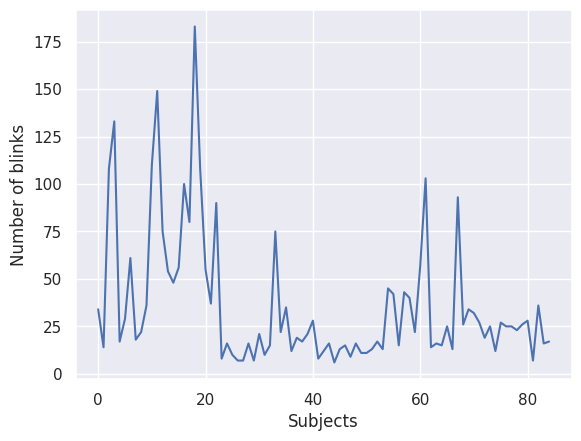

In [25]:
plt.plot([blink_info[x]["blink_nr"] for x in blink_info.keys()])
plt.xlabel("Subjects")
plt.ylabel("Number of blinks")

0


(0.0, 1.0)

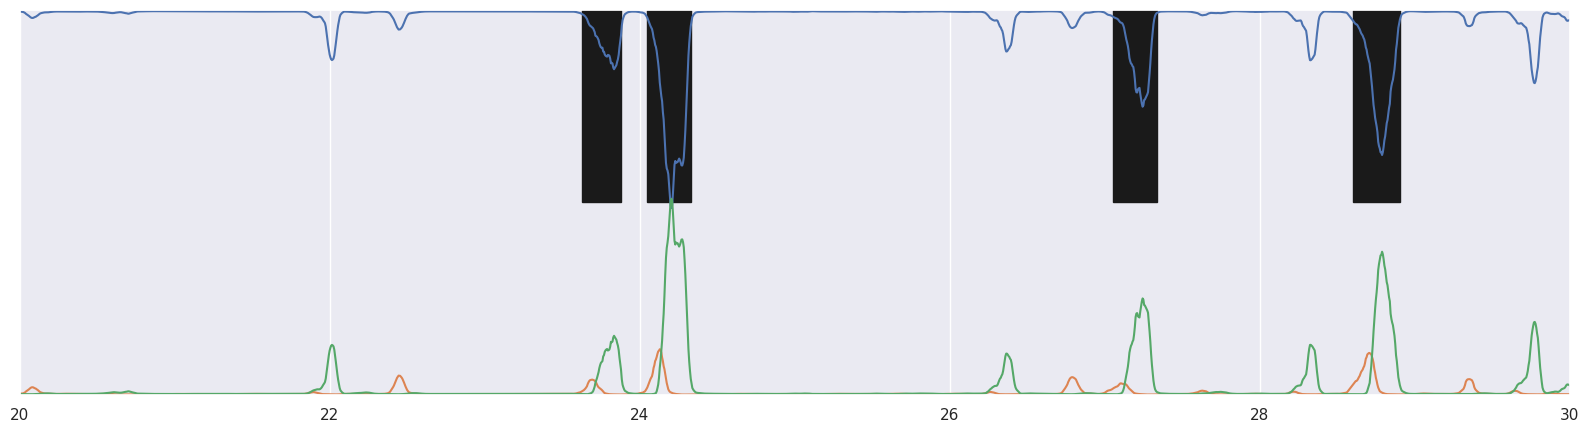

In [28]:
# precision = [len(blink_info[x]["tp"]) / (len(blink_info[x]["tp"]) + len(blink_info[x]["fp"])) for x in blink_info.keys()]

# recall = [len(blink_info[x]["tp"]) / (len(blink_info[x]["tp"]) + len(blink_info[x]["fn"])) for x in blink_info.keys()]

# plt.plot(precision)
# plt.plot(recall)

print(np.argmin(recall))


gt = blink_info["1311-2023-02-02-14-30-40-96be0928"]["gt"]
tp = blink_info["1311-2023-02-02-14-30-40-96be0928"]["tp"]

f, ax = plt.subplots(1, 1, figsize=(20, 5))

tp = np.array([tp[x][1] for x in range(len(tp))])

pf.render_event_array(ax, np.array(gt)[:, 0], np.array(gt)[:, 1], 0.5, color="k")
pf.render_event_array(ax, np.array(tp)[:, 0], np.array(tp)[:, 1], 1, color="g")

t = np.arange(0, len((blink_info["1311-2023-02-02-14-30-40-96be0928"]["smoothed_proba"])))/200

plt.plot(t, blink_info["1311-2023-02-02-14-30-40-96be0928"]["smoothed_proba"])

plt.xlim(20, 30)
plt.ylim (0, 1)

array([[  36,   70],
       [7181, 7224]])

In [2]:
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

import notebooks.plotting_functions as pf
from functions.pipeline import predict_and_evaluate, predict
from helper import OfParams, PPParams, AugParams
aug_params = AugParams()

of_params, pp_params = pf.get_params()


clip_name = "1002-2022-12-14-11-43-58-23e05b8c"

# feature_array, ts = pf.compute_optical_flow(clip_name)

# load timestamps




proba = predict(ts, feature_array, of_params, aug_params)
blink_array, _ = post_process_debug(timestamps, proba, pp_params)
blink_array_gt = get_blink_array_gt(recording_name, timestamps)
scores = get_event_based_metrics(blink_array_gt, blink_array)

# n_blinks = len(blink_array_gt.labels[blink_array_gt.labels == label_mapping.blink])
# return scores, n_blinks





FileNotFoundError: [Errno 2] No such file or directory: '/users/tom/git/neon_blink_detection/export-XGBClassifier-3-300320231716/n_lay5-lay_intv7-grid4-win15-trans0-scale0.0-speed0.0/weights-0.sav'

In [76]:
from training.helper import ClassifierParams

ClassifierParams("XGB", "XGBoost")

ClassifierParams(name='XGB', algorithm='XGBoost', kwargs={})